## Supernova SNR metric

This metric corresponds to the detection rate of a faint [(x1,color) = (-2.0,0.2)] supernovae. It is estimated by comparing,at a given time MJD$_{cur}$,the Signal-to-Noise Ratio (SNR) of a supernovae with T0=MJD$_{cur}$ -10 to the SNR one would have with a regular cadence SNR$_{ref}$(mean value of the corresponding period of study) : if SNR $≥$ SNR$_{ref}$, the supernovae can be detected.This metric is sensitive to internight gap variations.
### Input parameters
- band
- z : redshift value for the study
- Li_files : list of npy files with light curves
- mag_to_flux : list of npy files with mag to flux conversion
- config_fake : dict of parameters to simulate "fake" observations (to estimate SNRrefref)



## imports

In [1]:
%matplotlib inline
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import sqlite3
import numpy as np
from lsst.sims.maf.metrics.snSNRMetric import SNSNRMetric
from lsst.sims.maf.utils.snUtils import ReferenceData

## DB file choice

In [2]:
dbName = 'kraken_2026.db'
dbFile = dbName #'/home/philippe/LSST/DB_Files/{}'.format(dbName)
opsimdb = db.OpsimDatabase(dbFile)
# version = opsimdb.opsimVersion
# propinfo, proptags = opsimdb.fetchPropInfo()
# print('proptags and propinfo', proptags, propinfo)
runLength = opsimdb.fetchRunLength()

## Field choice (DD or WFD)

In [3]:
fieldtype='WFD' #fieldtype: DD or WFD

sqlconstraint = '' #opsimdb.createSQLWhere(fieldtype, proptags)


if fieldtype == 'DD':
    coadd = True
    fracmin = 0.05
    fracmax = 1.0
if fieldtype == 'WFD':
    coadd = False
    fracmin = 0.05
    fracmax = 1.0
    
Li_files = ['../../data/Li_SNCosmo_-2.0_0.2.npy']
mag_to_flux_files = ['../../data/Mag_to_Flux_SNCosmo.npy']
names_ref = ['SNCosmo']

In [4]:
bands = 'r'
z=0.3

plotDict = {'title': 'Redshift limit',
                'xlabel': 'Detection rate','xMin':fracmin,'xMax':fracmax,'nTicks':10,
           'colorMin': fracmin,'colorMax':fracmax}

plotDict['bins'] = np.arange(0.,0.5,0.05)

# Load sn lc info and mags
lim_sn = {}
for band in bands:
    lim_sn[band] = ReferenceData(
                Li_files,mag_to_flux_files,band, z)


## Define slicer

In [5]:
slicer = slicers.HealpixSlicer(nside=64)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


## Make the bundle

### To run over a set of seasons

In [6]:
bundleList= []
yearDates = list(range(0, int(round(365 * runLength)) + 365, 365))

for band in bands: #Loop on the bands
    sql_i = ''
    sql_i += 'filter = "%s"' % (band) #sql constraint on the band
    
    for season in range(1,2):
        metric = SNSNRMetric(lim_sn=lim_sn[band], coadd=coadd, names_ref=names_ref,
                             season= [season],z=0.3)

        plotDict['title'] = 'season {} - {} band - z={}'.format(season,band,z)
            
        sql_y = sql_i + ' AND night > %i AND night <= %i' % (
                    yearDates[np.max([0,season-2])], yearDates[np.min([9,season + 2])]) #sql constraint on the year   
        bundleList.append(metricBundles.MetricBundle(
            metric, slicer, sql_y, runName= '{}_{}'.format(dbName,season),plotDict=plotDict))
print(len(bundleList))

1


### To run over the complete sample

In [7]:
bundleList= []
yearDates = list(range(0, int(round(365 * runLength)) + 365, 365))

for band in bands: #Loop on the bands
    sql_i = ''
    sql_i += 'filter = "%s"' % (band) #sql constraint on the band
 
    metric = SNSNRMetric(lim_sn=lim_sn[band], coadd=coadd, names_ref=names_ref,
                             season=-1,z=0.3)

    plotDict['title'] = '{} band - z={}'.format(band,z)
            
    
    bundleList.append(metricBundles.MetricBundle(
            metric, slicer, sql_i, runName= '{}'.format(dbName),plotDict=plotDict))
print(len(bundleList))

1


## Run 

In [8]:
import time
time_ref = time.time()
outDir = '{}_Cadence'.format(dbName)
resultsDb = db.ResultsDb(outDir=outDir)
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsimdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()
print('Processing time',time.time()-time_ref)

Querying database SummaryAllProps with constraint filter = "r" for columns ['observationStartMJD', 'fieldRA', 'observationId', 'night', 'fieldDec', 'numExposures', 'fiveSigmaDepth', 'filter', 'visitTime', 'visitExposureTime']
Found 532326 visits
Running:  ['kraken_2026_db_SNSNRMetric_r_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Processing time 1363.5876111984253


## Plot the results

Plotting figures with "filter = "r"" constraint now.
monopole: 0.354101  dipole: lon: 121.039, lat: 41.6947, amp: 0.019569
Plotting complete.


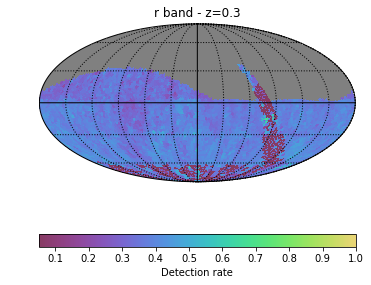

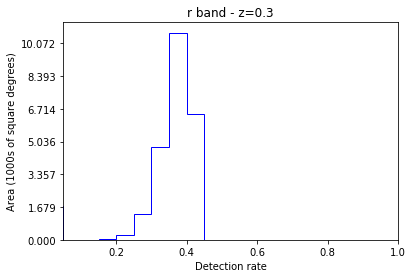

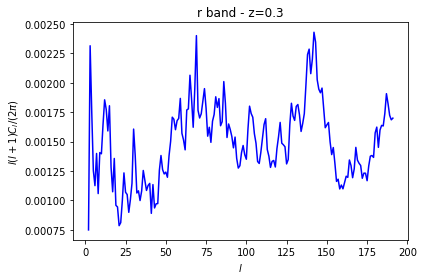

In [9]:
bgroup.plotAll(closefigs=False)